<a href="https://colab.research.google.com/github/Rhino-byte/Time-Series-/blob/main/Cryptocurrency_Analysis_In_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this Research we will be building GARCH models and Seasonal ARIMA models to help us analyse the patterns in the BITCOIN cryptocurrency

In [ ]:
# Install neccesarry package
install.packages("zoo")
install.packages("xts")
install.packages("tidyverse")
install.packages("httr")
install.packages("jsonlite")
install.packages('quantmod')

library(xts)
library(zoo)
library(tidyverse)
library(httr)
library(jsonlite)
library(quantmod)

The data we are going to use is based from [Kraken](https://pro.kraken.com/) which we shall extract using API.Before proceeding make sure you have created an account in Kraken to access the API's.

In [60]:
#@title API KEYs
#  private key
api_key<-'TS7dqZAFi9QPHa3FQSW/YGvCBG+gGMMzZrhcqysq1bjKe0WoaOs4sm2rgr37RHZ+eI/iyxuu570DYcztPHO6uA=='
# API_key
api_secret<-'99VP7jA7/qu1DEIOl+4FxvR+nTpZh9QfSgx8vXL8FPM7tRMatQSzjfRL'

In [3]:
load_api_keys <- function () {
api_key <- Sys.getenv (" KRAKEN_API_KEY ")
api_secret <- Sys.getenv (" KRAKEN_API_SECRET ")
return ( list ( key = api_key , secret = api_secret ) )
}

initialize_kraken_api <- function () {
keys <- load_api_keys ()
list (
key = api_key,
secret = api_secret)
}

**Food for thought:**To access any API the key requirements:

* API Key or Secret (optional depending on type of API)
* The parametres of the data you want to extract
* The URL for the API you want to access your data from

In [4]:
get_ohlc_data <- function(pair = "XXBTZUSD", interval = 1440) {
  # Initialize Kraken API
  api <- initialize_kraken_api()

  # Kraken API endpoint
  url <- "https://api.kraken.com/0/public/OHLC"

  # Parameters for the request
  params <- list(
    pair = pair,
    interval = interval # The time frame we want to use for our garch models
  )

  # Make the GET request
  response <- GET(url, query = params)
  # Check the status code
  if (status_code(response) != 200) {
    stop("Failed to fetch data from Kraken API. Status code: ", status_code(response))
  }

  # Parse the response
  content <- fromJSON(content(response, "text"), flatten = TRUE)

  # Extract OHLC data
  ohlc_data <- content$result[[pair]]

  if (is.null(ohlc_data)) {
    stop("No data found for the given pair.")
  }

  # Convert to data frame
  ohlc_df <- as.data.frame(ohlc_data)
  colnames(ohlc_df) <- c("time", "open", "high", "low", "close", "vwap", "volume", "count")

  # Convert time from UNIX timestamp to readable date
  ohlc_df$time <- as.POSIXct(as.integer(ohlc_df$time))

  return(ohlc_df)
}

Our Parameters for this API is (pair and interval) for more on kraken API [Documentation](https://docs.kraken.com/api/docs/rest-api/get-ohlc-data)

```
(pair)
string
required
Asset pair to get data for
Example: XBTUSD

(interval)
integer
Possible values: [1, 5, 15, 30, 60, 240, 1440, 10080, 21600]
Default value: 1
Time frame interval in minutes
Example: 60

(since)
integer
Return OHLC entries since the given timestamp (intended for incremental updates)
Maximum value of data you can retrieve is 720 observation from the recent observation

Example: 1688671200
```

In [30]:
BTC_data = get_ohlc_data(interval= 5 )

No encoding supplied: defaulting to UTF-8.



In [31]:
# Convert all variables to numerical
BTC_data %>% mutate_if(is.character,as.numeric)->BTC_data

In [32]:
tail(BTC_data)

,time,open,high,low,close,vwap,volume,count
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
715,2024-10-19 11:30:00,68222.4,68222.4,68171.4,68172.0,68210.7,6.61056509,90
716,2024-10-19 11:35:00,68172.0,68172.1,68090.0,68127.8,68150.0,11.77799269,212
717,2024-10-19 11:40:00,68126.2,68136.0,68126.0,68132.7,68131.6,0.40145975,49
718,2024-10-19 11:45:00,68132.8,68178.0,68132.8,68154.3,68162.4,0.12969048,69
719,2024-10-19 11:50:00,68154.4,68154.4,68090.0,68099.9,68109.0,0.89923472,98
720,2024-10-19 11:55:00,68090.1,68100.0,68090.0,68099.9,68090.6,0.07368813,21


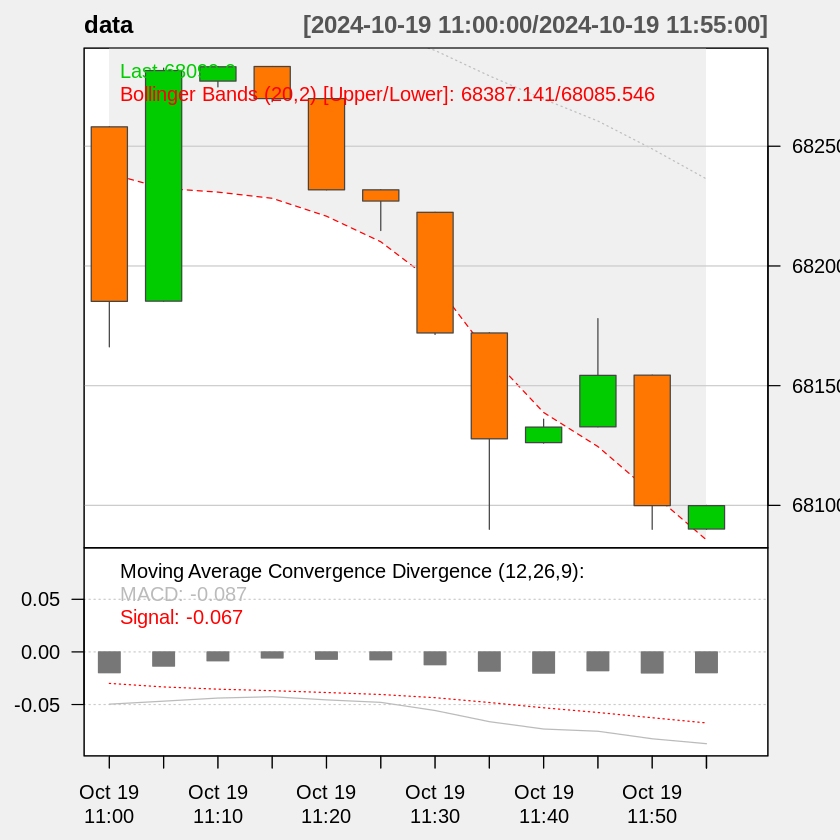

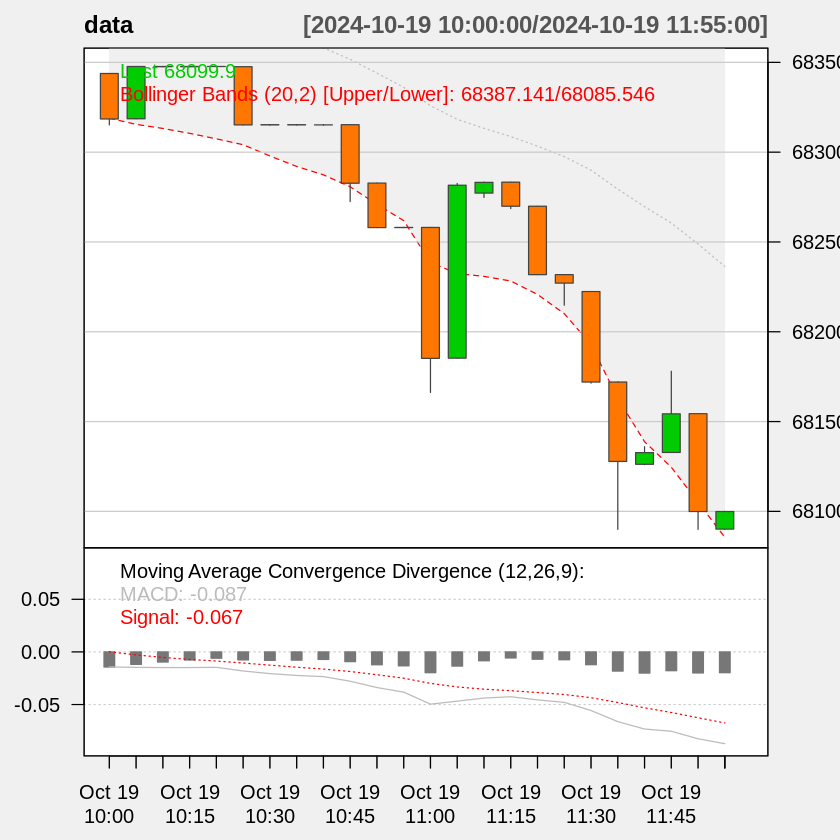

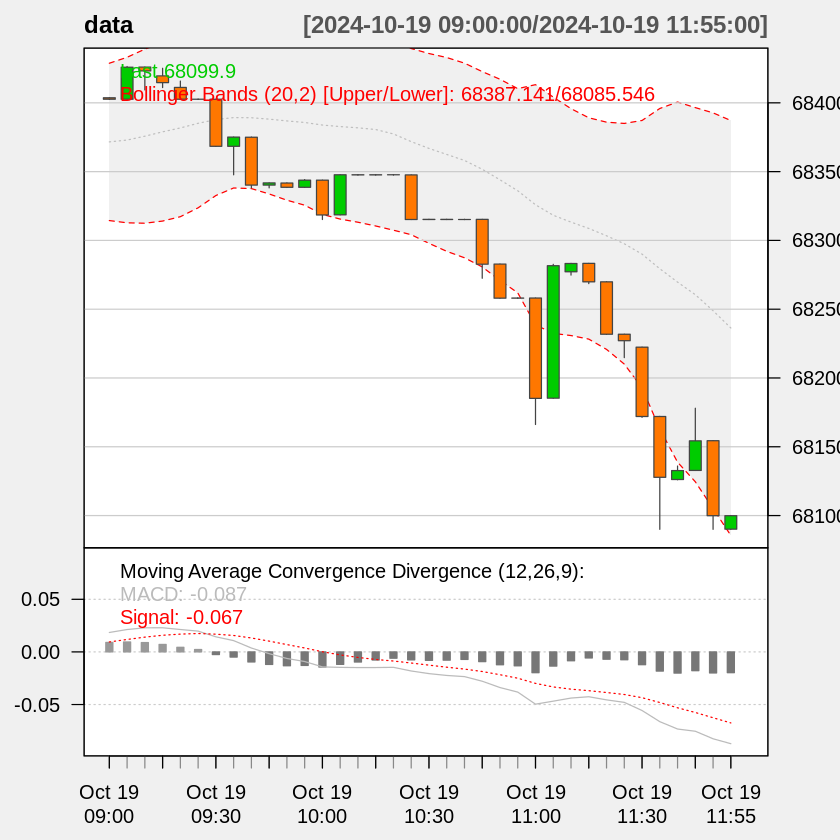

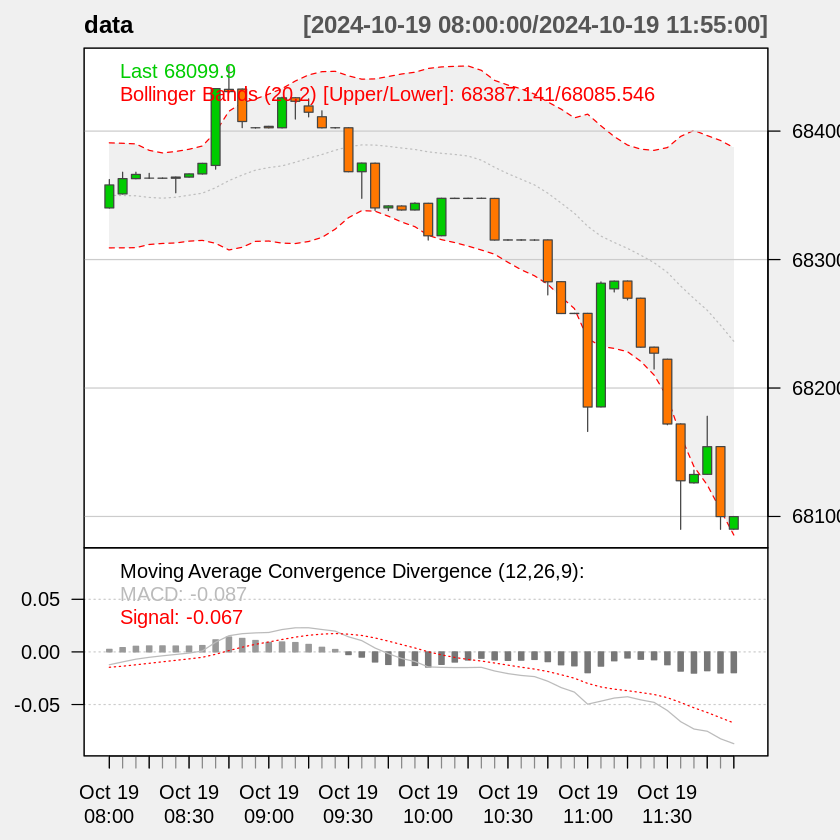

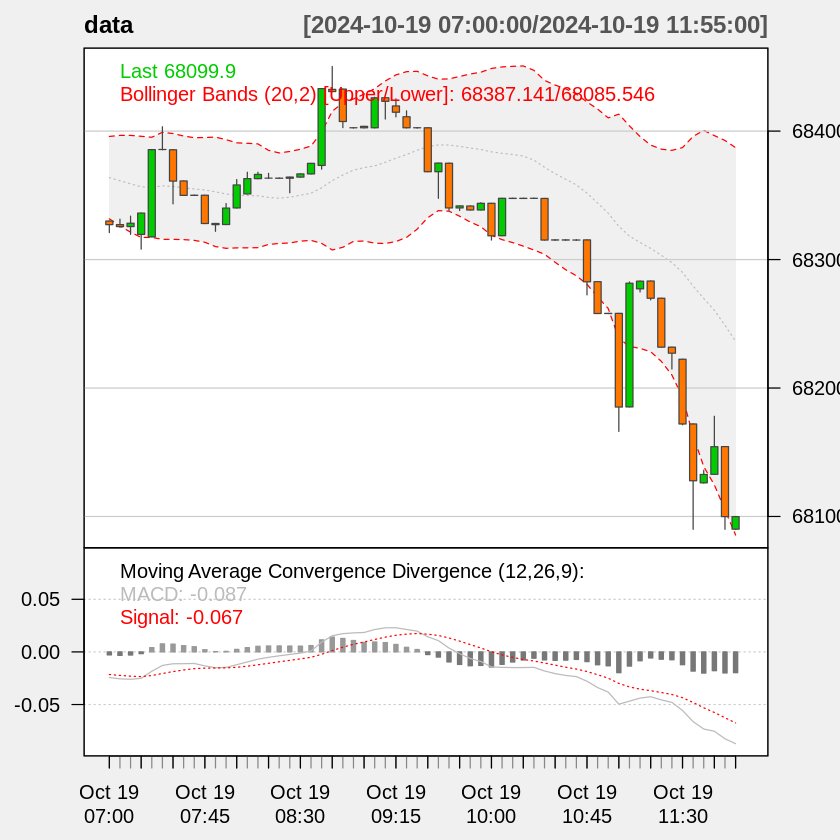

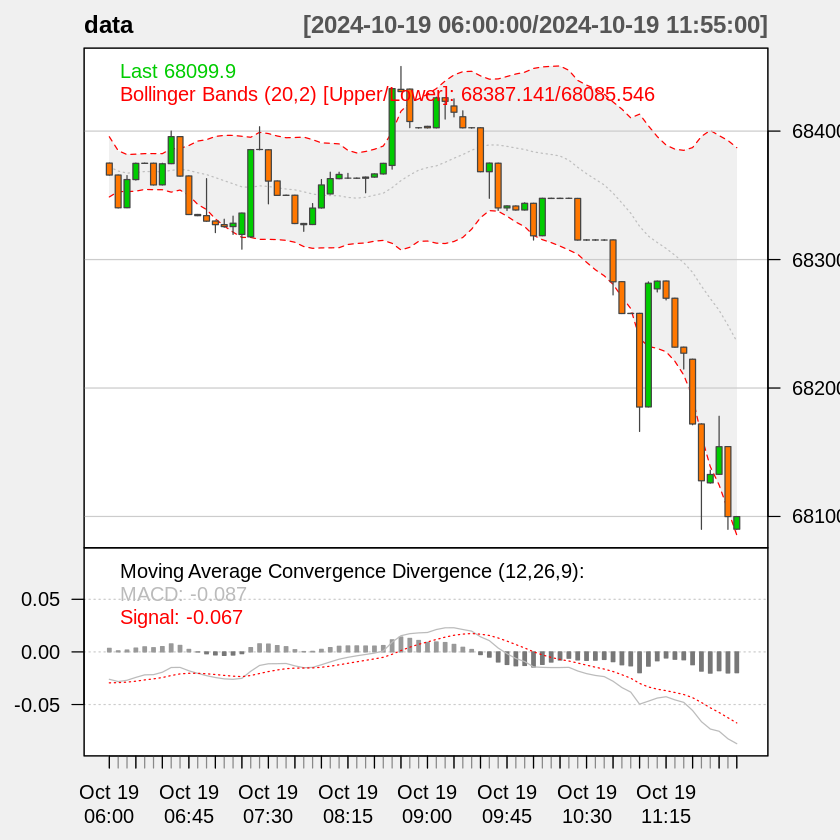

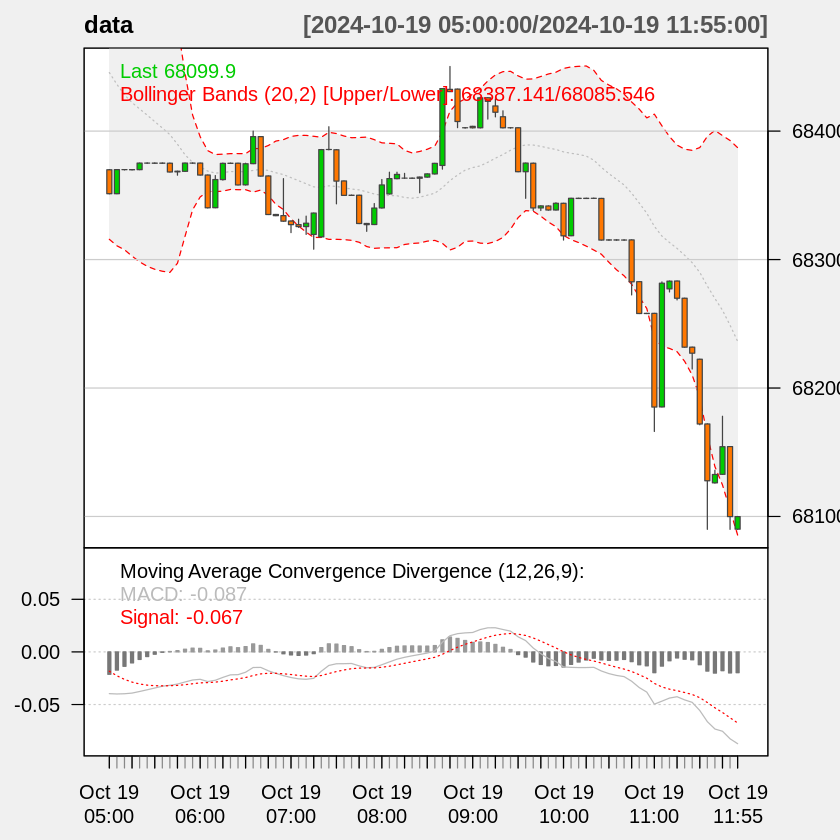

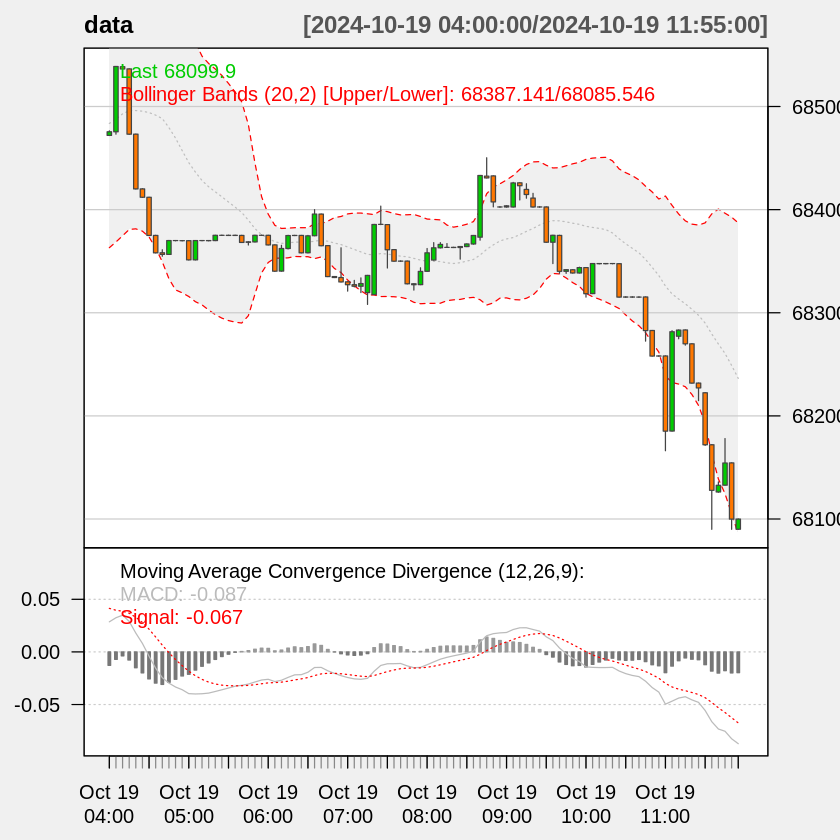

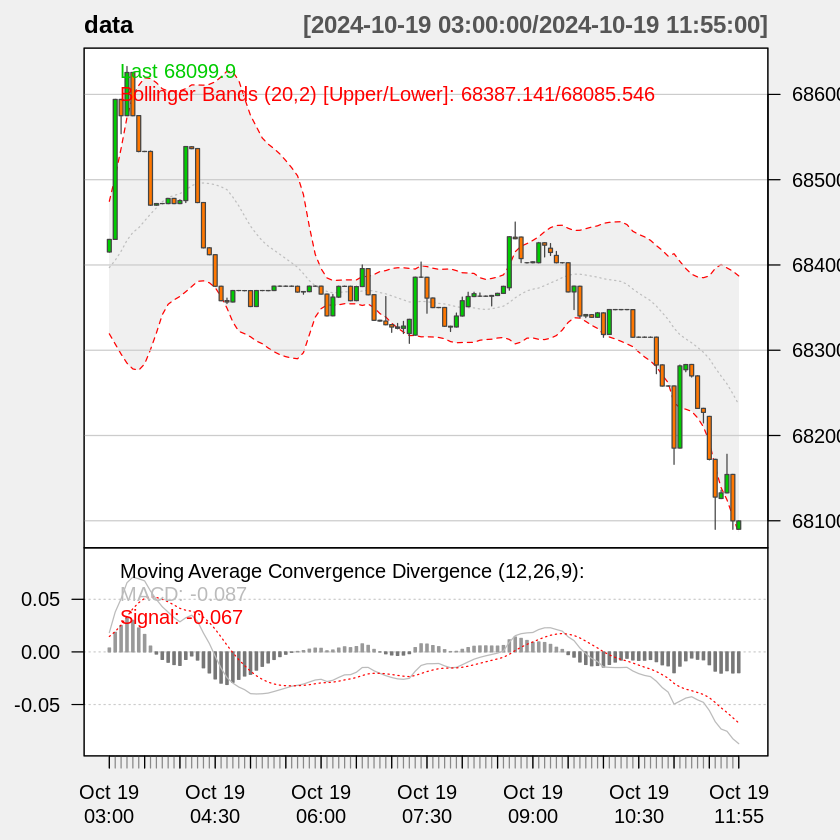

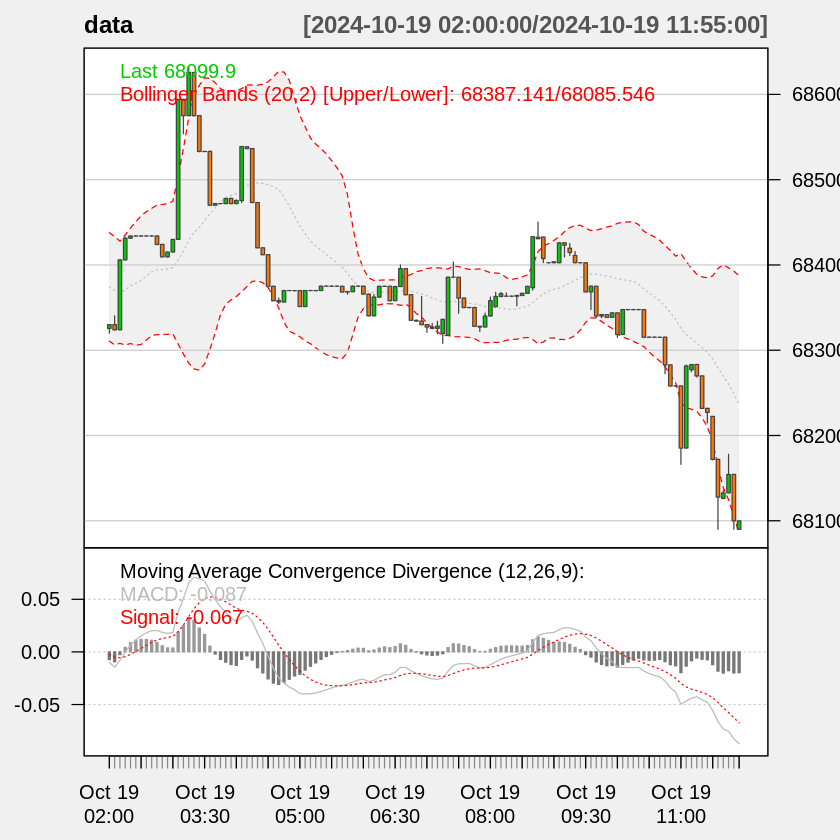

In [34]:
# plot the data
plot_series_chart<- function(data,n=4,time_interval = 'hour'){
chartSeries(
  x = data,
  theme=chartTheme('white'),
  subset=paste('last',n,time_interval),
  TA = c(
    quantmod::addMACD(),
    quantmod::addBBands()
  ))
}

for(i in 1:10){
  plot_series_chart(BTC_data,n=i)
  }

By looping over our plot function with changing the size of the data while also looking at the trends formed in our time series data.It was fun🤯


In [9]:
names(BTC_data)

[1] "time"   "open"   "high"   "low"    "close"  "vwap"   "volume" "count"

What are **Asset returns:**🥸

The **price** of an asset as a function of time is perhaps the most natural financial time series, but it is not the best way to manipulate the data mathematically.

The price of any reasonable asset will increase exponentially with time, but most of our mathematical tools (e.g. correlation, regression) work most naturally with linear functions.

The mean value of an exponentially-increasing time series has no obvious meaning.
There are various types of returns but for this study we will use the [logarithimc(Compound)](https://saturncloud.io/blog/what-are-logarithmic-returns-and-how-to-calculate-them-in-pandas-dataframe/#:~:text=Logarithmic%20returns%20are%20also%20useful,over%20a%20period%20of%20time.) returns.

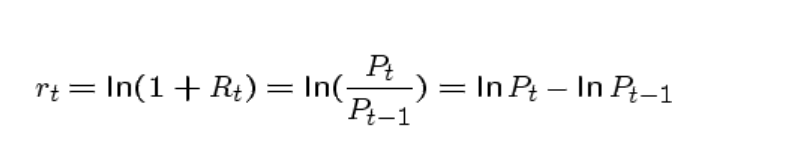

## Properties of Assets returns

If we consider the returns of a volatile asset, such the daily return on a stock, we would expect:

* The expected value will be small, probably near zero. Think about 10% return divided by 365 days.

* There should be a gross symmetry between negative returns and positive returns.

* Smaller absolute returns will occur more frequently than larger absolute returns

More notes on the [PerformanceAnalytics]('https://cran.r-project.org/web/packages/PerformanceAnalytics/PerformanceAnalytics.pdf') package

In [72]:
# Install package for calculating returns(also good for financial time series)
install.packages("PerformanceAnalytics")
install.packages("forecast")
# install.packages('cowplot')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



To calculate the returns we use the closing prices of the stock index

In [61]:
# Extract the returns
library(PerformanceAnalytics)
returns =  CalculateReturns(as.ts(BTC_data$close),'compound')[-1]
# head(returns)
# We need to remove the missing value this is brought about differencing the data
# returns = returns[-1] #The first element
length(returns)


[1] 719

## ACF and PACF plots 🧐

[Autocorrelation](https://www.influxdata.com/blog/autocorrelation-in-time-series-data/)
 refers to the degree of similarity between A) a given time series, and B) a lagged version of itself, over C) successive time intervals. In other words, autocorrelation is intended to measure the relationship between a variable’s present value and any past values that you may have access to.


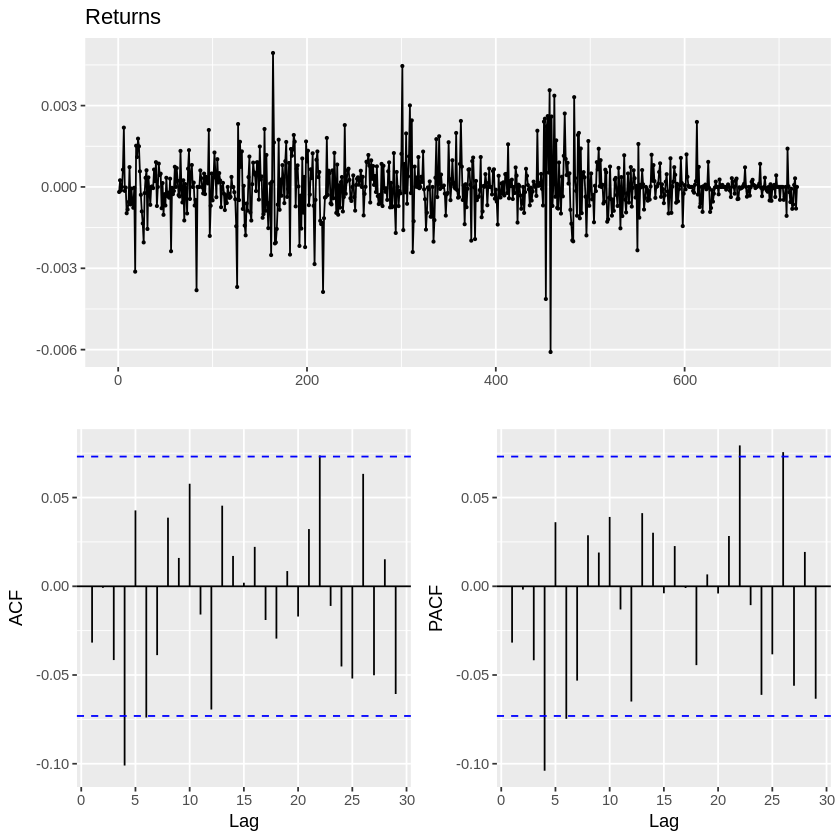

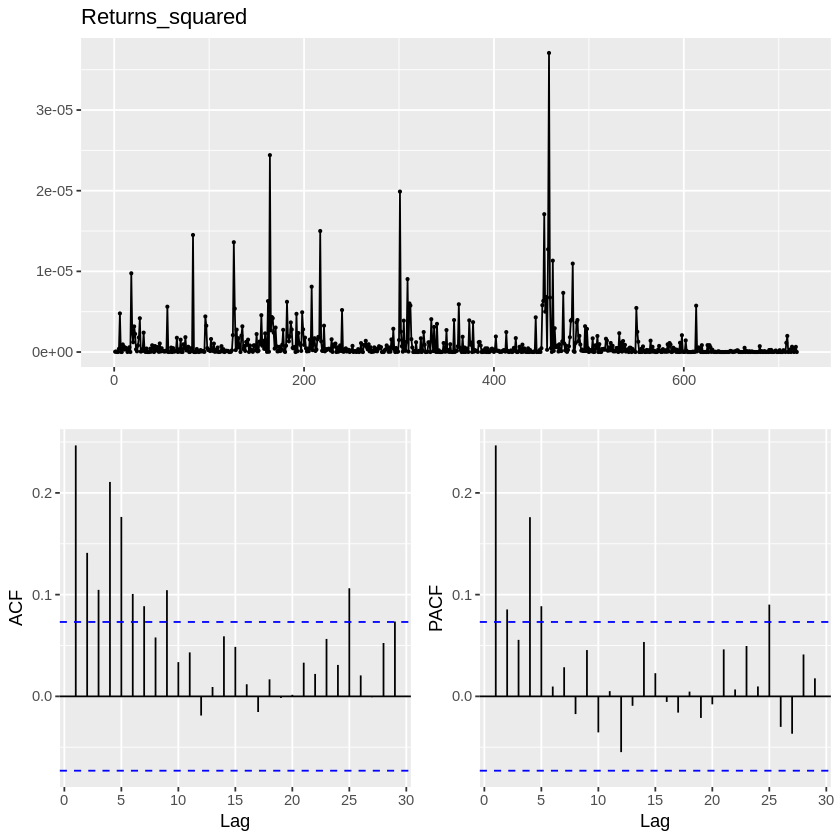

In [81]:
library(forecast)
library(cowplot)
# Plot the returns and the returns_squared
ggtsdisplay(returns,main ='Returns')
ggtsdisplay(returns^2,main='Returns_squared')



In [10]:
safe_model_fit <- function(fit_function, model_name) {
    tryCatch({
      model <- fit_function()
      forecast <- forecast::forecast(model, h = length(test_data))$mean
      ic <- AIC(model)
      model_smape <- smape(test_data, forecast)
      list(Order = list(arimaorder(model)), Error = FALSE, IC = ic, SMAPE = model_smape)
    }, error = function(e) {
      # If the model fails, return NA and mark as error
      list(Order = list(NA), Error = TRUE, IC = NA, SMAPE = NA)
    })
  }